### Architecture idea (SIMPLE DIAGRAM)

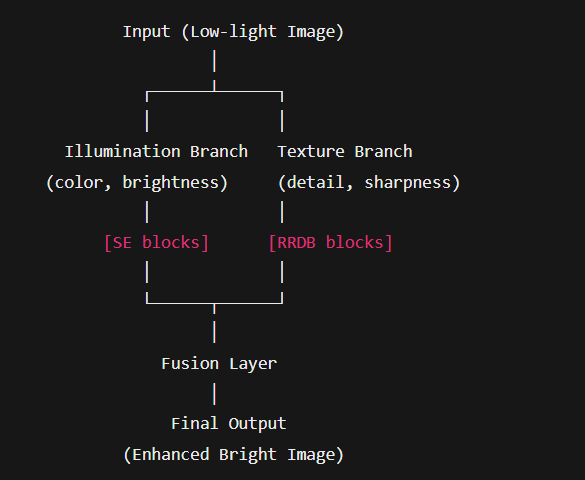

In [1]:
!pip install numpy
!pip install torchmetrics
!pip install piq
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import PeakSignalNoiseRatio as PSNR, StructuralSimilarityIndexMeasure as SSIM
from piq import LPIPS
import os
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision.utils import save_image
from torchvision.datasets import DatasetFolder
from datetime import datetime
from sklearn.model_selection import train_test_split

In [2]:
# def set_seed(seed=42):
#     """Set all random seeds for reproducibility."""
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)  # if using multi-GPU
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# # Set the seed (choose any number you like)
# set_seed(42) 

# Run Data

In [3]:
dataset_path1 = '/home/tdiykanba2/codes/RRDB_SE_CHECKPOINTS_color_jitter/augmented_images'
train_path = f'{dataset_path1}/train'
val_path = f'{dataset_path1}/val'
test_path = f'{dataset_path1}/test'

In [4]:
target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [5]:
class CleanDataset(Dataset):
    def __init__(self, root_dir, target_transform=None):
        self.root_dir = root_dir
        self.target_transform = target_transform
        self.low_dir = os.path.join(root_dir, "low")
        self.high_dir = os.path.join(root_dir, "high")
        self.image_names = sorted(os.listdir(self.low_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.target_transform:
            low_img = self.target_transform(low_img)
            high_img = self.target_transform(high_img)
            
            
        low_filename = os.path.basename(low_img_path)
        high_filename = os.path.basename(high_img_path)
        
        return low_img, high_img, low_filename, high_filename

train_dataset = CleanDataset(
    root_dir=train_path, 
    target_transform = target_transform
)

val_dataset = CleanDataset(
    root_dir=val_path,
    target_transform = target_transform
)

test_dataset = CleanDataset(root_dir=test_path, target_transform = target_transform)

In [6]:
batch_size=8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True   # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,         # No need for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,       # Often use batch_size=1 for testing
    shuffle=False,
    num_workers=1
)

In [7]:
def show_true_images(low_batch, high_batch, n=4):

    """
    Shows EXACTLY what's in your dataset with correct color handling.
    Works for both normalized and unnormalized images.
    """

    plt.figure(figsize=(18, 8))

    for i in range(min(n, len(low_batch))):
        # --- Low-light ---
        plt.subplot(2, n, i+1)
        low_img = low_batch[i].permute(1, 2, 0).numpy()

        # Handle normalization if present
        if low_img.min() < 0:  # Likely normalized
            low_img = (low_img * 0.5 + 0.5)  # Reverse imagenet norm

        # Ensure proper image range
        low_img = np.clip(low_img, 0, 1)
        plt.imshow(low_img)
        plt.title(f"Low")
        plt.axis('off')

        # --- Normal-light ---
        plt.subplot(2, n, n+i+1)
        high_img = high_batch[i].permute(1, 2, 0).numpy()

        if high_img.min() < 0:  # Likely normalized
            high_img = (high_img * 0.5 + 0.5)

        high_img = np.clip(high_img, 0, 1)
        plt.imshow(high_img)
        plt.title(f"High")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Low resolution file name: ['480.png', '644.png', '736.png', '231.png', '531.png', '576.png', '95.png', '485.png']
High resolution file name: ['480.png', '644.png', '736.png', '231.png', '531.png', '576.png', '95.png', '485.png']


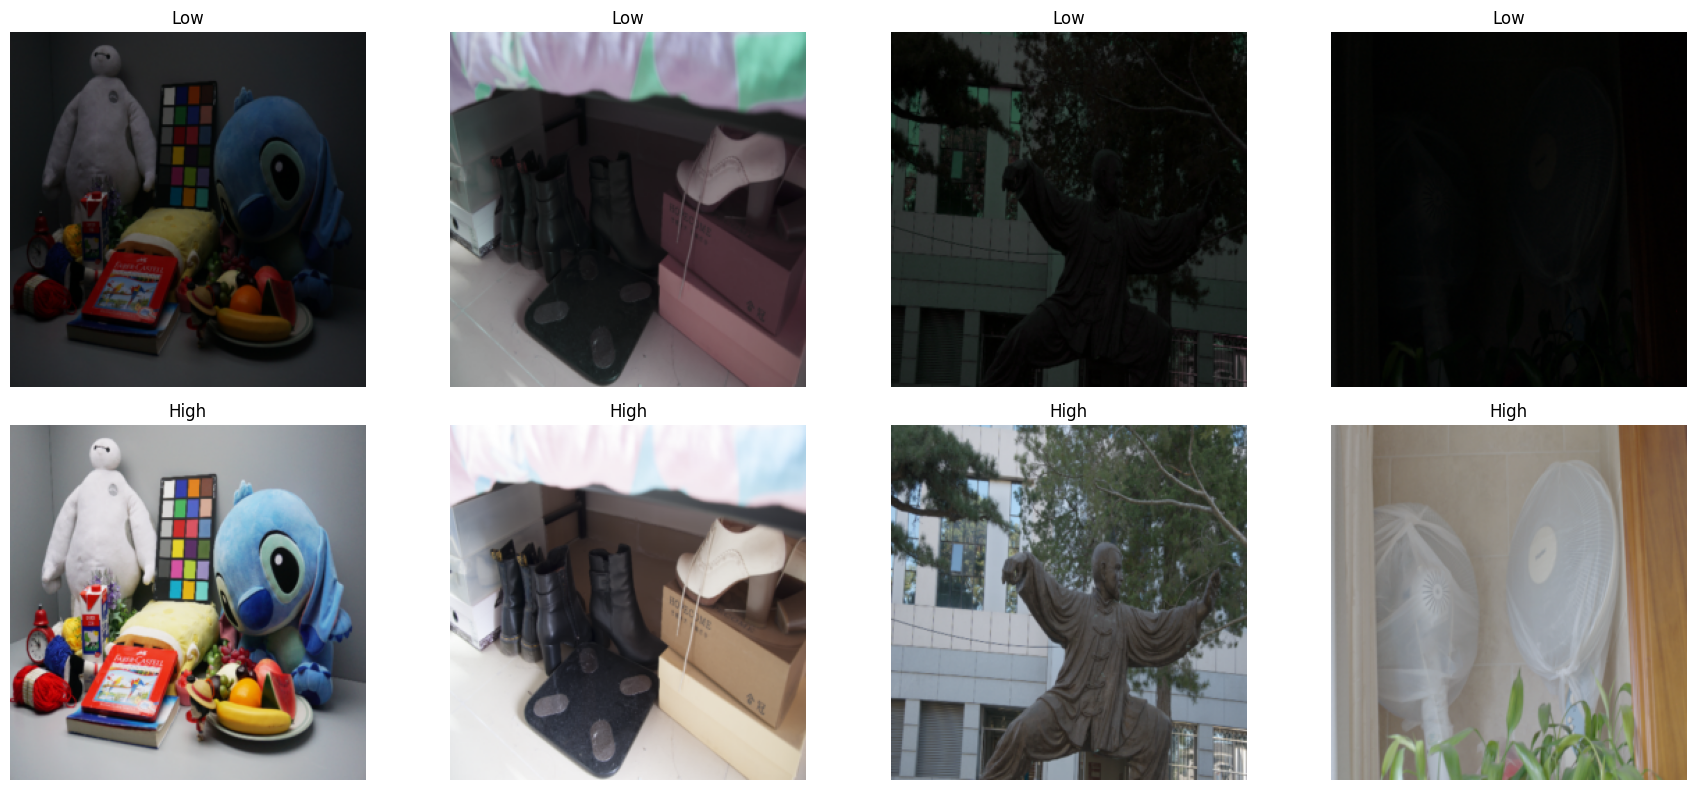

In [8]:
low, high, low_filename, high_filename = next(iter(train_loader))
print("Low resolution file name:", low_filename)
print("High resolution file name:", high_filename)
show_true_images(low, high)

# MODEL ARCHITECTURE

In [9]:
#SE Blocks:

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""

    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


# Residual-in-Residual Dense Block (RRDB)

class RRDB(nn.Module):
    """Residual-in-Residual Dense Block"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels*2, channels, 3, padding=1)
        self.conv3 = nn.Conv2d(channels*3, channels, 3, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.se = SEBlock(channels)

    def forward(self, x):
        out1 = self.lrelu(self.conv1(x))
        out2 = self.lrelu(self.conv2(torch.cat([x, out1], 1)))
        out3 = self.conv3(torch.cat([x, out1, out2], 1))
        return self.se(out3 * 0.2 + x)  # Residual scaling


Generator


In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Illumination Branch (color/brightness)
        self.illum_conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.illum_rrdb = nn.Sequential(*[RRDB(32) for _ in range(4)])
        self.illum_conv2 = nn.Conv2d(32, 3, 3, padding=1)

        # Texture Branch (detail/sharpness)
        self.texture_conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.texture_rrdb = nn.Sequential(*[RRDB(64) for _ in range(6)])
        self.texture_conv2 = nn.Conv2d(64, 3, 3, padding=1)

        # Fusion
        self.fusion = nn.Sequential(
            nn.Conv2d(6, 32, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()  # Output in [-1,1] -> remap to [0,1] later
        )

    def forward(self, x):
        # Illumination path
        illum = self.illum_conv1(x)
        illum = self.illum_rrdb(illum)
        illum = torch.sigmoid(self.illum_conv2(illum))  # [0,1]

        # Texture path
        texture = self.texture_conv1(x)
        texture = self.texture_rrdb(texture)
        texture = self.texture_conv2(texture)  # No activation (keep details)

        # Fusion
        fused = self.fusion(torch.cat([illum, texture], 1))
        return (fused + 1) / 2  # Map to [0,1]

Discriminator

In [11]:
class Discriminator(nn.Module):
    """PatchGAN discriminator"""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input: 3 x 256 x 256
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # 128
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 64
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 32
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=1, padding=1),  # 31
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)  # 30x30 patch output
        )

    def forward(self, x):
        return self.model(x)

Loss Functions


In [12]:
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
        return self.loss(pred, target)


class PerceptualLoss(nn.Module):

    """VGG-based perceptual loss"""

    def __init__(self):
        super().__init__()
        vgg = vgg19(pretrained=True).features[:16]
        self.vgg = nn.Sequential(*[m for m in vgg if not isinstance(m, nn.MaxPool2d)])
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input = F.interpolate(input, size=(224,224)) if input.shape[-1] != 224 else input
        vgg_target = F.interpolate(target, size=(224,224)) if target.shape[-1] != 224 else target
        return F.l1_loss(self.vgg(vgg_input), self.vgg(vgg_target))

# Training preparation:

In [13]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Hyperparameters
config = {
    'batch_size': 8,
    'epochs': 200,
    'lr_g': 2e-4,
    'lr_d': 1e-4,
    'betas': (0.5, 0.999),
    'lambda_l1': 100,
    'lambda_perceptual': 0.1,
    'save_interval': 1,  # Save every epoch
    'sample_interval': 100,  # Generate samples every N batches
}

# Initialize models and losses
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Losses
criterion_gan = GANLoss()
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

# Optimizers with LR scheduling
opt_g = torch.optim.Adam(generator.parameters(), lr=config['lr_g'], betas=config['betas'])
opt_d = torch.optim.Adam(discriminator.parameters(), lr=config['lr_d'], betas=config['betas'])
scheduler_g = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_g, 'min', patience=5, factor=0.5)
scheduler_d = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_d, 'min', patience=5, factor=0.5)

# Initialize metrics
psnr = PSNR().to(device)
ssim = SSIM().to(device)
lpips = LPIPS(replace_pooling=True).to(device)

/home/tdiykanba2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchmetrics/utilit

# Training LOOP

In [14]:
def validate(generator, val_loader, epoch):
    """Evaluate model on validation set"""
    generator.eval()
    val_metrics = {'psnr': 0, 'ssim': 0, 'lpips': 0}

    with torch.no_grad():
        for low, high, *_ in tqdm(val_loader, desc=f'Validation Epoch {epoch}', leave=False):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            val_metrics['psnr'] += psnr(fake, high)
            val_metrics['ssim'] += ssim(fake, high)
            val_metrics['lpips'] += lpips(fake, high)

    # Average across batches
    for k in val_metrics:
        val_metrics[k] /= len(val_loader)

    return val_metrics

In [15]:
def train_gan(
    generator,
    discriminator,
    train_loader,
    val_loader,
    criterion_gan,
    criterion_l1,
    criterion_perceptual,
    opt_g,
    opt_d,
    epochs,
    device,
    save_dir="RRDB_SE_CHECKPOINTS_color_jitter"
):
    os.makedirs(save_dir, exist_ok=True)
    best_ssim = 0
    best_lpips = 100
    best_psnr = 0

    for epoch in range(epochs):
        # Training phase
        generator.train()
        discriminator.train()

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for low, high, *_ in train_bar:
            low, high = low.to(device), high.to(device)

            # --- Discriminator Update ---
            opt_d.zero_grad()

            # Real images
            real_pred = discriminator(high)
            real_loss = criterion_gan(real_pred, True)

            # Fake images
            fake = generator(low).detach()
            fake_pred = discriminator(fake)
            fake_loss = criterion_gan(fake_pred, False)

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            opt_d.step()

            # --- Generator Update ---
            opt_g.zero_grad()
            fake = generator(low)
            g_gan_loss = criterion_gan(discriminator(fake), True)
            g_l1_loss = criterion_l1(fake, high) * 100
            g_perc_loss = criterion_perceptual(fake, high) * 0.1
            g_loss = g_gan_loss + g_l1_loss + g_perc_loss
            g_loss.backward()
            opt_g.step()

            # Update progress bar
            train_bar.set_postfix({
                'D_loss': f'{d_loss.item():.3f}',
                'G_loss': f'{g_loss.item():.3f}',
                'L1': f'{g_l1_loss.item():.3f}'
            })

        # Validation phase
        val_metrics = validate(generator, val_loader, epoch+1)

        # Print metrics
        print(f"\nValidation @ Epoch {epoch+1}:")
        print(f"PSNR: {val_metrics['psnr']:.2f} dB | SSIM: {val_metrics['ssim']:.4f} | LPIPS: {val_metrics['lpips']:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch+1,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'opt_g': opt_g.state_dict(),
            'opt_d': opt_d.state_dict(),
            'metrics': val_metrics
        }, os.path.join(save_dir, f'epoch_{epoch+1}.pth'))

        # Save best model
        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
            print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
                
        if val_metrics['ssim'] > best_ssim:
            best_ssim = val_metrics['ssim']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
            print(f"🔥 New best model (SSIM: {best_ssim:.4f}) saved!")
                    
        if val_metrics['psnr'] > best_psnr:
            best_psnr = val_metrics['psnr']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
            print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")

        if val_metrics['lpips'] < best_lpips:
            best_lpips = val_metrics['lpips']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
            print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")

            
        # Sample images
        if (epoch+1) % 5 == 0:
            with torch.no_grad():
                fake = generator(low[:3])  # First 3 samples
                save_image(
                    torch.cat([low[:3], fake, high[:3]], 0),
                    os.path.join(save_dir, f'sample_epoch_{epoch+1}.png'),
                    nrow=3,
                    normalize=True
                )


In [16]:
# Usage
train_gan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_gan=criterion_gan,
    criterion_l1=criterion_l1,
    criterion_perceptual=criterion_perceptual,
    opt_g=opt_g,
    opt_d=opt_d,
    epochs=200,
    device=device
)

Epoch 1/200: 100%|█| 49/49 [00:27<00:00,  1.81it/s, D_loss=0.131, G_loss=19.015,
                                                                                


Validation @ Epoch 1:
PSNR: 14.52 dB | SSIM: 0.5569 | LPIPS: 0.6104
🔥 New best model (PSNR: 14.5245 | LPIPS: 0.6104 | SSIM: 0.5569) saved!
🔥 New best model (LPIPS: 0.6104 | SSIM: 0.5569) saved!
🔥 New best model (PSNR: 14.5245 | SSIM: 0.5569) saved!
🔥 New best model (PSNR: 14.5245 | LPIPS: 0.6104) saved!
🔥 New best model (SSIM: 0.5569) saved!
🔥 New best model (PSNR: 14.5245) saved!
🔥 New best model (LPIPS: 0.6104) saved!


Epoch 2/200: 100%|█| 49/49 [00:24<00:00,  2.03it/s, D_loss=0.185, G_loss=18.228,
                                                                                


Validation @ Epoch 2:
PSNR: 15.28 dB | SSIM: 0.6156 | LPIPS: 0.5218
🔥 New best model (PSNR: 15.2820 | LPIPS: 0.5218 | SSIM: 0.6156) saved!
🔥 New best model (LPIPS: 0.5218 | SSIM: 0.6156) saved!
🔥 New best model (PSNR: 15.2820 | SSIM: 0.6156) saved!
🔥 New best model (PSNR: 15.2820 | LPIPS: 0.5218) saved!
🔥 New best model (SSIM: 0.6156) saved!
🔥 New best model (PSNR: 15.2820) saved!
🔥 New best model (LPIPS: 0.5218) saved!


Epoch 3/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.220, G_loss=12.026,
                                                                                


Validation @ Epoch 3:
PSNR: 15.56 dB | SSIM: 0.6326 | LPIPS: 0.4966
🔥 New best model (PSNR: 15.5639 | LPIPS: 0.4966 | SSIM: 0.6326) saved!
🔥 New best model (LPIPS: 0.4966 | SSIM: 0.6326) saved!
🔥 New best model (PSNR: 15.5639 | SSIM: 0.6326) saved!
🔥 New best model (PSNR: 15.5639 | LPIPS: 0.4966) saved!
🔥 New best model (SSIM: 0.6326) saved!
🔥 New best model (PSNR: 15.5639) saved!
🔥 New best model (LPIPS: 0.4966) saved!


Epoch 4/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.273, G_loss=11.708,
                                                                                


Validation @ Epoch 4:
PSNR: 16.60 dB | SSIM: 0.6546 | LPIPS: 0.4885
🔥 New best model (PSNR: 16.5981 | LPIPS: 0.4885 | SSIM: 0.6546) saved!
🔥 New best model (LPIPS: 0.4885 | SSIM: 0.6546) saved!
🔥 New best model (PSNR: 16.5981 | SSIM: 0.6546) saved!
🔥 New best model (PSNR: 16.5981 | LPIPS: 0.4885) saved!
🔥 New best model (SSIM: 0.6546) saved!
🔥 New best model (PSNR: 16.5981) saved!
🔥 New best model (LPIPS: 0.4885) saved!


Epoch 5/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.263, G_loss=11.093,
                                                                                


Validation @ Epoch 5:
PSNR: 16.93 dB | SSIM: 0.6540 | LPIPS: 0.4616
🔥 New best model (PSNR: 16.9319 | LPIPS: 0.4616) saved!
🔥 New best model (PSNR: 16.9319) saved!
🔥 New best model (LPIPS: 0.4616) saved!


Epoch 6/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.476, G_loss=14.568,
                                                                                


Validation @ Epoch 6:
PSNR: 16.92 dB | SSIM: 0.6751 | LPIPS: 0.4398
🔥 New best model (LPIPS: 0.4398 | SSIM: 0.6751) saved!
🔥 New best model (SSIM: 0.6751) saved!
🔥 New best model (LPIPS: 0.4398) saved!


Epoch 7/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.142, G_loss=10.922,
                                                                                


Validation @ Epoch 7:
PSNR: 17.20 dB | SSIM: 0.7269 | LPIPS: 0.3974
🔥 New best model (PSNR: 17.1989 | LPIPS: 0.3974 | SSIM: 0.7269) saved!
🔥 New best model (LPIPS: 0.3974 | SSIM: 0.7269) saved!
🔥 New best model (PSNR: 17.1989 | SSIM: 0.7269) saved!
🔥 New best model (PSNR: 17.1989 | LPIPS: 0.3974) saved!
🔥 New best model (SSIM: 0.7269) saved!
🔥 New best model (PSNR: 17.1989) saved!
🔥 New best model (LPIPS: 0.3974) saved!


Epoch 8/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.663, G_loss=16.187,
                                                                                


Validation @ Epoch 8:
PSNR: 16.63 dB | SSIM: 0.6949 | LPIPS: 0.4772


Epoch 9/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.366, G_loss=16.949,
                                                                                


Validation @ Epoch 9:
PSNR: 17.73 dB | SSIM: 0.7375 | LPIPS: 0.3864
🔥 New best model (PSNR: 17.7343 | LPIPS: 0.3864 | SSIM: 0.7375) saved!
🔥 New best model (LPIPS: 0.3864 | SSIM: 0.7375) saved!
🔥 New best model (PSNR: 17.7343 | SSIM: 0.7375) saved!
🔥 New best model (PSNR: 17.7343 | LPIPS: 0.3864) saved!
🔥 New best model (SSIM: 0.7375) saved!
🔥 New best model (PSNR: 17.7343) saved!
🔥 New best model (LPIPS: 0.3864) saved!


Epoch 10/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.272, G_loss=12.874
                                                                                


Validation @ Epoch 10:
PSNR: 17.43 dB | SSIM: 0.7139 | LPIPS: 0.4770


Epoch 11/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.510, G_loss=16.542
                                                                                


Validation @ Epoch 11:
PSNR: 17.31 dB | SSIM: 0.7365 | LPIPS: 0.3834
🔥 New best model (LPIPS: 0.3834) saved!


Epoch 12/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.182, G_loss=12.379
                                                                                


Validation @ Epoch 12:
PSNR: 16.87 dB | SSIM: 0.6725 | LPIPS: 0.4173


Epoch 13/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.291, G_loss=9.370,
                                                                                


Validation @ Epoch 13:
PSNR: 17.77 dB | SSIM: 0.7465 | LPIPS: 0.3787
🔥 New best model (PSNR: 17.7732 | LPIPS: 0.3787 | SSIM: 0.7465) saved!
🔥 New best model (LPIPS: 0.3787 | SSIM: 0.7465) saved!
🔥 New best model (PSNR: 17.7732 | SSIM: 0.7465) saved!
🔥 New best model (PSNR: 17.7732 | LPIPS: 0.3787) saved!
🔥 New best model (SSIM: 0.7465) saved!
🔥 New best model (PSNR: 17.7732) saved!
🔥 New best model (LPIPS: 0.3787) saved!


Epoch 14/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.410, G_loss=14.230
                                                                                


Validation @ Epoch 14:
PSNR: 17.30 dB | SSIM: 0.7210 | LPIPS: 0.4050


Epoch 15/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.667, G_loss=16.001
                                                                                


Validation @ Epoch 15:
PSNR: 17.62 dB | SSIM: 0.7148 | LPIPS: 0.3734
🔥 New best model (LPIPS: 0.3734) saved!


Epoch 16/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.606, G_loss=12.826
                                                                                


Validation @ Epoch 16:
PSNR: 16.79 dB | SSIM: 0.7101 | LPIPS: 0.3944


Epoch 17/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.187, G_loss=10.442
                                                                                


Validation @ Epoch 17:
PSNR: 18.32 dB | SSIM: 0.7738 | LPIPS: 0.3551
🔥 New best model (PSNR: 18.3187 | LPIPS: 0.3551 | SSIM: 0.7738) saved!
🔥 New best model (LPIPS: 0.3551 | SSIM: 0.7738) saved!
🔥 New best model (PSNR: 18.3187 | SSIM: 0.7738) saved!
🔥 New best model (PSNR: 18.3187 | LPIPS: 0.3551) saved!
🔥 New best model (SSIM: 0.7738) saved!
🔥 New best model (PSNR: 18.3187) saved!
🔥 New best model (LPIPS: 0.3551) saved!


Epoch 18/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.109, G_loss=16.341
                                                                                


Validation @ Epoch 18:
PSNR: 17.48 dB | SSIM: 0.7715 | LPIPS: 0.3659


Epoch 19/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.505, G_loss=12.610
                                                                                


Validation @ Epoch 19:
PSNR: 17.63 dB | SSIM: 0.7203 | LPIPS: 0.3876


Epoch 20/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.341, G_loss=14.649
                                                                                


Validation @ Epoch 20:
PSNR: 17.31 dB | SSIM: 0.7799 | LPIPS: 0.3474
🔥 New best model (LPIPS: 0.3474 | SSIM: 0.7799) saved!
🔥 New best model (SSIM: 0.7799) saved!
🔥 New best model (LPIPS: 0.3474) saved!


Epoch 21/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.236, G_loss=11.699
                                                                                


Validation @ Epoch 21:
PSNR: 18.08 dB | SSIM: 0.7933 | LPIPS: 0.3347
🔥 New best model (LPIPS: 0.3347 | SSIM: 0.7933) saved!
🔥 New best model (SSIM: 0.7933) saved!
🔥 New best model (LPIPS: 0.3347) saved!


Epoch 22/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.285, G_loss=12.252
                                                                                


Validation @ Epoch 22:
PSNR: 17.79 dB | SSIM: 0.7633 | LPIPS: 0.3490


Epoch 23/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.188, G_loss=16.993
                                                                                


Validation @ Epoch 23:
PSNR: 16.86 dB | SSIM: 0.6887 | LPIPS: 0.4253


Epoch 24/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.197, G_loss=14.105
                                                                                


Validation @ Epoch 24:
PSNR: 17.25 dB | SSIM: 0.7564 | LPIPS: 0.3404


Epoch 25/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.194, G_loss=11.003
                                                                                


Validation @ Epoch 25:
PSNR: 17.60 dB | SSIM: 0.7664 | LPIPS: 0.3457


Epoch 26/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.422, G_loss=9.673,
                                                                                


Validation @ Epoch 26:
PSNR: 17.96 dB | SSIM: 0.7973 | LPIPS: 0.3235
🔥 New best model (LPIPS: 0.3235 | SSIM: 0.7973) saved!
🔥 New best model (SSIM: 0.7973) saved!
🔥 New best model (LPIPS: 0.3235) saved!


Epoch 27/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.390, G_loss=10.008
                                                                                


Validation @ Epoch 27:
PSNR: 18.14 dB | SSIM: 0.7796 | LPIPS: 0.3466


Epoch 28/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.416, G_loss=11.086
                                                                                


Validation @ Epoch 28:
PSNR: 18.70 dB | SSIM: 0.8056 | LPIPS: 0.3077
🔥 New best model (PSNR: 18.6969 | LPIPS: 0.3077 | SSIM: 0.8056) saved!
🔥 New best model (LPIPS: 0.3077 | SSIM: 0.8056) saved!
🔥 New best model (PSNR: 18.6969 | SSIM: 0.8056) saved!
🔥 New best model (PSNR: 18.6969 | LPIPS: 0.3077) saved!
🔥 New best model (SSIM: 0.8056) saved!
🔥 New best model (PSNR: 18.6969) saved!
🔥 New best model (LPIPS: 0.3077) saved!


Epoch 29/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.276, G_loss=8.452,
                                                                                


Validation @ Epoch 29:
PSNR: 18.89 dB | SSIM: 0.8195 | LPIPS: 0.2841
🔥 New best model (PSNR: 18.8907 | LPIPS: 0.2841 | SSIM: 0.8195) saved!
🔥 New best model (LPIPS: 0.2841 | SSIM: 0.8195) saved!
🔥 New best model (PSNR: 18.8907 | SSIM: 0.8195) saved!
🔥 New best model (PSNR: 18.8907 | LPIPS: 0.2841) saved!
🔥 New best model (SSIM: 0.8195) saved!
🔥 New best model (PSNR: 18.8907) saved!
🔥 New best model (LPIPS: 0.2841) saved!


Epoch 30/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.154, G_loss=13.405
                                                                                


Validation @ Epoch 30:
PSNR: 19.13 dB | SSIM: 0.8218 | LPIPS: 0.2984
🔥 New best model (PSNR: 19.1277 | SSIM: 0.8218) saved!
🔥 New best model (SSIM: 0.8218) saved!
🔥 New best model (PSNR: 19.1277) saved!


Epoch 31/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.241, G_loss=15.987
                                                                                


Validation @ Epoch 31:
PSNR: 18.90 dB | SSIM: 0.8114 | LPIPS: 0.2741
🔥 New best model (LPIPS: 0.2741) saved!


Epoch 32/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.327, G_loss=10.632
                                                                                


Validation @ Epoch 32:
PSNR: 19.04 dB | SSIM: 0.8296 | LPIPS: 0.2698
🔥 New best model (LPIPS: 0.2698 | SSIM: 0.8296) saved!
🔥 New best model (SSIM: 0.8296) saved!
🔥 New best model (LPIPS: 0.2698) saved!


Epoch 33/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.178, G_loss=14.789
                                                                                


Validation @ Epoch 33:
PSNR: 18.92 dB | SSIM: 0.8283 | LPIPS: 0.2734


Epoch 34/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.077, G_loss=18.100
                                                                                


Validation @ Epoch 34:
PSNR: 18.96 dB | SSIM: 0.8199 | LPIPS: 0.2705


Epoch 35/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.523, G_loss=11.509
                                                                                


Validation @ Epoch 35:
PSNR: 18.64 dB | SSIM: 0.8221 | LPIPS: 0.2904


Epoch 36/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.210, G_loss=11.057
                                                                                


Validation @ Epoch 36:
PSNR: 19.15 dB | SSIM: 0.8198 | LPIPS: 0.2870
🔥 New best model (PSNR: 19.1528) saved!


Epoch 37/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.465, G_loss=8.008,
                                                                                


Validation @ Epoch 37:
PSNR: 18.46 dB | SSIM: 0.8117 | LPIPS: 0.2970


Epoch 38/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.172, G_loss=13.746
                                                                                


Validation @ Epoch 38:
PSNR: 19.06 dB | SSIM: 0.8256 | LPIPS: 0.2891


Epoch 39/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.240, G_loss=6.368,
                                                                                


Validation @ Epoch 39:
PSNR: 18.89 dB | SSIM: 0.8291 | LPIPS: 0.2933


Epoch 40/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.301, G_loss=12.202
                                                                                


Validation @ Epoch 40:
PSNR: 18.49 dB | SSIM: 0.8210 | LPIPS: 0.3071


Epoch 41/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.331, G_loss=15.853
                                                                                


Validation @ Epoch 41:
PSNR: 19.03 dB | SSIM: 0.8315 | LPIPS: 0.2758
🔥 New best model (SSIM: 0.8315) saved!


Epoch 42/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.179, G_loss=9.260,
                                                                                


Validation @ Epoch 42:
PSNR: 19.07 dB | SSIM: 0.8276 | LPIPS: 0.2918


Epoch 43/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.216, G_loss=14.918
                                                                                


Validation @ Epoch 43:
PSNR: 18.63 dB | SSIM: 0.8360 | LPIPS: 0.2545
🔥 New best model (LPIPS: 0.2545 | SSIM: 0.8360) saved!
🔥 New best model (SSIM: 0.8360) saved!
🔥 New best model (LPIPS: 0.2545) saved!


Epoch 44/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.317, G_loss=16.512
                                                                                


Validation @ Epoch 44:
PSNR: 18.24 dB | SSIM: 0.8260 | LPIPS: 0.2713


Epoch 45/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.286, G_loss=12.330
                                                                                


Validation @ Epoch 45:
PSNR: 18.27 dB | SSIM: 0.8034 | LPIPS: 0.3213


Epoch 46/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.224, G_loss=9.770,
                                                                                


Validation @ Epoch 46:
PSNR: 18.78 dB | SSIM: 0.8029 | LPIPS: 0.2954


Epoch 47/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.643, G_loss=8.531,
                                                                                


Validation @ Epoch 47:
PSNR: 19.04 dB | SSIM: 0.8274 | LPIPS: 0.2540
🔥 New best model (LPIPS: 0.2540) saved!


Epoch 48/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.751, G_loss=9.492,
                                                                                


Validation @ Epoch 48:
PSNR: 18.43 dB | SSIM: 0.8117 | LPIPS: 0.2746


Epoch 49/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.579, G_loss=11.362
                                                                                


Validation @ Epoch 49:
PSNR: 19.06 dB | SSIM: 0.8178 | LPIPS: 0.2804


Epoch 50/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.100, G_loss=12.094
                                                                                


Validation @ Epoch 50:
PSNR: 17.77 dB | SSIM: 0.7961 | LPIPS: 0.3137


Epoch 51/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.280, G_loss=14.847
                                                                                


Validation @ Epoch 51:
PSNR: 18.54 dB | SSIM: 0.7959 | LPIPS: 0.2948


Epoch 52/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.479, G_loss=16.662
                                                                                


Validation @ Epoch 52:
PSNR: 17.98 dB | SSIM: 0.8169 | LPIPS: 0.2626


Epoch 53/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.354, G_loss=7.635,
                                                                                


Validation @ Epoch 53:
PSNR: 18.86 dB | SSIM: 0.8227 | LPIPS: 0.2669


Epoch 54/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.537, G_loss=7.393,
                                                                                


Validation @ Epoch 54:
PSNR: 18.89 dB | SSIM: 0.8277 | LPIPS: 0.2679


Epoch 55/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.232, G_loss=8.203,
                                                                                


Validation @ Epoch 55:
PSNR: 18.75 dB | SSIM: 0.8242 | LPIPS: 0.2734


Epoch 56/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.380, G_loss=13.054
                                                                                


Validation @ Epoch 56:
PSNR: 18.33 dB | SSIM: 0.7823 | LPIPS: 0.3585


Epoch 57/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.176, G_loss=13.939
                                                                                


Validation @ Epoch 57:
PSNR: 18.08 dB | SSIM: 0.7992 | LPIPS: 0.3321


Epoch 58/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.181, G_loss=9.901,
                                                                                


Validation @ Epoch 58:
PSNR: 18.89 dB | SSIM: 0.8136 | LPIPS: 0.2708


Epoch 59/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.436, G_loss=13.353
                                                                                


Validation @ Epoch 59:
PSNR: 18.95 dB | SSIM: 0.8268 | LPIPS: 0.2732


Epoch 60/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.298, G_loss=12.257
                                                                                


Validation @ Epoch 60:
PSNR: 18.58 dB | SSIM: 0.8166 | LPIPS: 0.2838


Epoch 61/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.355, G_loss=11.807
                                                                                


Validation @ Epoch 61:
PSNR: 19.04 dB | SSIM: 0.8201 | LPIPS: 0.2718


Epoch 62/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.186, G_loss=13.904
                                                                                


Validation @ Epoch 62:
PSNR: 18.03 dB | SSIM: 0.7688 | LPIPS: 0.3310


Epoch 63/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.205, G_loss=11.511
                                                                                


Validation @ Epoch 63:
PSNR: 18.99 dB | SSIM: 0.8253 | LPIPS: 0.2623


Epoch 64/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.215, G_loss=11.227
                                                                                


Validation @ Epoch 64:
PSNR: 18.67 dB | SSIM: 0.8178 | LPIPS: 0.2648


Epoch 65/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.483, G_loss=14.709
                                                                                


Validation @ Epoch 65:
PSNR: 19.03 dB | SSIM: 0.8192 | LPIPS: 0.2786


Epoch 66/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.211, G_loss=9.760,
                                                                                


Validation @ Epoch 66:
PSNR: 19.15 dB | SSIM: 0.8310 | LPIPS: 0.2581
🔥 New best model (PSNR: 19.1549) saved!


Epoch 67/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.327, G_loss=12.503
                                                                                


Validation @ Epoch 67:
PSNR: 18.66 dB | SSIM: 0.8271 | LPIPS: 0.2824


Epoch 68/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.260, G_loss=10.958
                                                                                


Validation @ Epoch 68:
PSNR: 18.90 dB | SSIM: 0.8263 | LPIPS: 0.2508
🔥 New best model (LPIPS: 0.2508) saved!


Epoch 69/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.337, G_loss=11.160
                                                                                


Validation @ Epoch 69:
PSNR: 18.60 dB | SSIM: 0.8217 | LPIPS: 0.2706


Epoch 70/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.315, G_loss=14.438
                                                                                


Validation @ Epoch 70:
PSNR: 19.19 dB | SSIM: 0.8321 | LPIPS: 0.2587
🔥 New best model (PSNR: 19.1865) saved!


Epoch 71/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.257, G_loss=9.822,
                                                                                


Validation @ Epoch 71:
PSNR: 18.79 dB | SSIM: 0.8307 | LPIPS: 0.2578


Epoch 72/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.298, G_loss=9.708,
                                                                                


Validation @ Epoch 72:
PSNR: 18.86 dB | SSIM: 0.8193 | LPIPS: 0.2912


Epoch 73/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.340, G_loss=12.297
                                                                                


Validation @ Epoch 73:
PSNR: 18.31 dB | SSIM: 0.8270 | LPIPS: 0.2584


Epoch 74/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.443, G_loss=15.714
                                                                                


Validation @ Epoch 74:
PSNR: 18.67 dB | SSIM: 0.8187 | LPIPS: 0.2852


Epoch 75/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.569, G_loss=10.807
                                                                                


Validation @ Epoch 75:
PSNR: 18.45 dB | SSIM: 0.8044 | LPIPS: 0.3004


Epoch 76/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.177, G_loss=15.569
                                                                                


Validation @ Epoch 76:
PSNR: 18.09 dB | SSIM: 0.8223 | LPIPS: 0.2515


Epoch 77/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.178, G_loss=14.077
                                                                                


Validation @ Epoch 77:
PSNR: 18.10 dB | SSIM: 0.8239 | LPIPS: 0.2667


Epoch 78/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.244, G_loss=17.422
                                                                                


Validation @ Epoch 78:
PSNR: 18.66 dB | SSIM: 0.8168 | LPIPS: 0.3108


Epoch 79/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.406, G_loss=11.879
                                                                                


Validation @ Epoch 79:
PSNR: 18.79 dB | SSIM: 0.8269 | LPIPS: 0.2571


Epoch 80/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.356, G_loss=13.625
                                                                                


Validation @ Epoch 80:
PSNR: 18.61 dB | SSIM: 0.8225 | LPIPS: 0.2747


Epoch 81/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.225, G_loss=10.023
                                                                                


Validation @ Epoch 81:
PSNR: 19.07 dB | SSIM: 0.8173 | LPIPS: 0.2956


Epoch 82/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.283, G_loss=9.192,
                                                                                


Validation @ Epoch 82:
PSNR: 18.89 dB | SSIM: 0.8292 | LPIPS: 0.2716


Epoch 83/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.187, G_loss=15.356
                                                                                


Validation @ Epoch 83:
PSNR: 18.85 dB | SSIM: 0.8296 | LPIPS: 0.2597


Epoch 84/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.239, G_loss=8.009,
                                                                                


Validation @ Epoch 84:
PSNR: 18.83 dB | SSIM: 0.8059 | LPIPS: 0.3133


Epoch 85/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.209, G_loss=10.869
                                                                                


Validation @ Epoch 85:
PSNR: 18.41 dB | SSIM: 0.8234 | LPIPS: 0.2677


Epoch 86/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.214, G_loss=11.803
                                                                                


Validation @ Epoch 86:
PSNR: 18.41 dB | SSIM: 0.8106 | LPIPS: 0.2605


Epoch 87/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.208, G_loss=9.582,
                                                                                


Validation @ Epoch 87:
PSNR: 19.01 dB | SSIM: 0.8324 | LPIPS: 0.2524


Epoch 88/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.172, G_loss=12.532
                                                                                


Validation @ Epoch 88:
PSNR: 18.92 dB | SSIM: 0.8170 | LPIPS: 0.2700


Epoch 89/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.552, G_loss=11.756
                                                                                


Validation @ Epoch 89:
PSNR: 18.55 dB | SSIM: 0.8083 | LPIPS: 0.2883


Epoch 90/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.058, G_loss=13.964
                                                                                


Validation @ Epoch 90:
PSNR: 19.32 dB | SSIM: 0.8290 | LPIPS: 0.2623
🔥 New best model (PSNR: 19.3152) saved!


Epoch 91/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.409, G_loss=11.883
                                                                                


Validation @ Epoch 91:
PSNR: 18.75 dB | SSIM: 0.8192 | LPIPS: 0.2623


Epoch 92/200: 100%|█| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.361, G_loss=7.058,
                                                                                


Validation @ Epoch 92:
PSNR: 18.13 dB | SSIM: 0.8170 | LPIPS: 0.2569


Epoch 93/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.335, G_loss=11.626
                                                                                


Validation @ Epoch 93:
PSNR: 19.05 dB | SSIM: 0.8292 | LPIPS: 0.2652


Epoch 94/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.276, G_loss=12.629
                                                                                


Validation @ Epoch 94:
PSNR: 17.98 dB | SSIM: 0.8162 | LPIPS: 0.2634


Epoch 95/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.234, G_loss=9.801,
                                                                                


Validation @ Epoch 95:
PSNR: 18.57 dB | SSIM: 0.8327 | LPIPS: 0.2656


Epoch 96/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.262, G_loss=8.966,
                                                                                


Validation @ Epoch 96:
PSNR: 18.62 dB | SSIM: 0.8225 | LPIPS: 0.2599


Epoch 97/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.182, G_loss=12.483
                                                                                


Validation @ Epoch 97:
PSNR: 18.70 dB | SSIM: 0.8185 | LPIPS: 0.2698


Epoch 98/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.556, G_loss=11.984
                                                                                


Validation @ Epoch 98:
PSNR: 18.79 dB | SSIM: 0.8273 | LPIPS: 0.2648


Epoch 99/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.142, G_loss=8.940,
                                                                                


Validation @ Epoch 99:
PSNR: 17.79 dB | SSIM: 0.8131 | LPIPS: 0.2500
🔥 New best model (LPIPS: 0.2500) saved!


Epoch 100/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.138, G_loss=12.50
                                                                                


Validation @ Epoch 100:
PSNR: 18.64 dB | SSIM: 0.8325 | LPIPS: 0.2593


Epoch 101/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.191, G_loss=15.77
                                                                                


Validation @ Epoch 101:
PSNR: 19.14 dB | SSIM: 0.8254 | LPIPS: 0.2598


Epoch 102/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.210, G_loss=11.64
                                                                                


Validation @ Epoch 102:
PSNR: 18.19 dB | SSIM: 0.8114 | LPIPS: 0.2633


Epoch 103/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.304, G_loss=9.930
                                                                                


Validation @ Epoch 103:
PSNR: 19.27 dB | SSIM: 0.8168 | LPIPS: 0.2678


Epoch 104/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.337, G_loss=11.99
                                                                                


Validation @ Epoch 104:
PSNR: 18.34 dB | SSIM: 0.8234 | LPIPS: 0.2712


Epoch 105/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.187, G_loss=15.44
                                                                                


Validation @ Epoch 105:
PSNR: 19.64 dB | SSIM: 0.8292 | LPIPS: 0.2586
🔥 New best model (PSNR: 19.6413) saved!


Epoch 106/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.133, G_loss=15.58
                                                                                


Validation @ Epoch 106:
PSNR: 19.21 dB | SSIM: 0.8246 | LPIPS: 0.2688


Epoch 107/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.344, G_loss=14.48
                                                                                


Validation @ Epoch 107:
PSNR: 18.89 dB | SSIM: 0.8242 | LPIPS: 0.2621


Epoch 108/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.402, G_loss=15.26
                                                                                


Validation @ Epoch 108:
PSNR: 18.83 dB | SSIM: 0.8120 | LPIPS: 0.2790


Epoch 109/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.320, G_loss=9.934
                                                                                


Validation @ Epoch 109:
PSNR: 19.11 dB | SSIM: 0.8318 | LPIPS: 0.2547


Epoch 110/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.174, G_loss=9.810
                                                                                


Validation @ Epoch 110:
PSNR: 18.49 dB | SSIM: 0.8255 | LPIPS: 0.2421
🔥 New best model (LPIPS: 0.2421) saved!


Epoch 111/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.139, G_loss=10.99
                                                                                


Validation @ Epoch 111:
PSNR: 19.17 dB | SSIM: 0.8315 | LPIPS: 0.2398
🔥 New best model (LPIPS: 0.2398) saved!


Epoch 112/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.314, G_loss=9.824
                                                                                


Validation @ Epoch 112:
PSNR: 18.62 dB | SSIM: 0.8218 | LPIPS: 0.2529


Epoch 113/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.123, G_loss=12.45
                                                                                


Validation @ Epoch 113:
PSNR: 18.77 dB | SSIM: 0.8274 | LPIPS: 0.2666


Epoch 114/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.267, G_loss=12.54
                                                                                


Validation @ Epoch 114:
PSNR: 18.79 dB | SSIM: 0.8130 | LPIPS: 0.2873


Epoch 115/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.302, G_loss=8.811
                                                                                


Validation @ Epoch 115:
PSNR: 19.28 dB | SSIM: 0.8272 | LPIPS: 0.2710


Epoch 116/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.236, G_loss=8.979
                                                                                


Validation @ Epoch 116:
PSNR: 19.18 dB | SSIM: 0.8110 | LPIPS: 0.2661


Epoch 117/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.126, G_loss=11.08
                                                                                


Validation @ Epoch 117:
PSNR: 18.96 dB | SSIM: 0.8240 | LPIPS: 0.2548


Epoch 118/200: 100%|█| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.194, G_loss=7.572
                                                                                


Validation @ Epoch 118:
PSNR: 18.79 dB | SSIM: 0.8164 | LPIPS: 0.2619


Epoch 119/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.126, G_loss=17.09
                                                                                


Validation @ Epoch 119:
PSNR: 17.83 dB | SSIM: 0.8149 | LPIPS: 0.2869


Epoch 120/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.394, G_loss=6.383
                                                                                


Validation @ Epoch 120:
PSNR: 19.42 dB | SSIM: 0.8312 | LPIPS: 0.2548


Epoch 121/200: 100%|█| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.144, G_loss=11.10
                                                                                


Validation @ Epoch 121:
PSNR: 18.58 dB | SSIM: 0.8148 | LPIPS: 0.2731


Epoch 122/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.479, G_loss=12.21
                                                                                


Validation @ Epoch 122:
PSNR: 18.67 dB | SSIM: 0.8233 | LPIPS: 0.2564


Epoch 123/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.238, G_loss=9.885
                                                                                


Validation @ Epoch 123:
PSNR: 19.13 dB | SSIM: 0.8310 | LPIPS: 0.2487


Epoch 124/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.174, G_loss=12.25
                                                                                


Validation @ Epoch 124:
PSNR: 19.18 dB | SSIM: 0.8199 | LPIPS: 0.2860


Epoch 125/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.131, G_loss=13.87
                                                                                


Validation @ Epoch 125:
PSNR: 19.27 dB | SSIM: 0.8177 | LPIPS: 0.2627


Epoch 126/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.118, G_loss=9.291
                                                                                


Validation @ Epoch 126:
PSNR: 19.31 dB | SSIM: 0.8169 | LPIPS: 0.2652


Epoch 127/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.146, G_loss=9.509
                                                                                


Validation @ Epoch 127:
PSNR: 18.81 dB | SSIM: 0.8198 | LPIPS: 0.2684


Epoch 128/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.378, G_loss=13.38
                                                                                


Validation @ Epoch 128:
PSNR: 18.54 dB | SSIM: 0.8222 | LPIPS: 0.2469


Epoch 129/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.096, G_loss=9.956
                                                                                


Validation @ Epoch 129:
PSNR: 19.48 dB | SSIM: 0.8337 | LPIPS: 0.2544


Epoch 130/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.496, G_loss=9.007
                                                                                


Validation @ Epoch 130:
PSNR: 18.25 dB | SSIM: 0.8295 | LPIPS: 0.2360
🔥 New best model (LPIPS: 0.2360) saved!


Epoch 131/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.241, G_loss=10.12
                                                                                


Validation @ Epoch 131:
PSNR: 19.00 dB | SSIM: 0.8302 | LPIPS: 0.2453


Epoch 132/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.332, G_loss=7.630
                                                                                


Validation @ Epoch 132:
PSNR: 19.46 dB | SSIM: 0.8248 | LPIPS: 0.2653


Epoch 133/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.210, G_loss=7.729
                                                                                


Validation @ Epoch 133:
PSNR: 18.81 dB | SSIM: 0.8180 | LPIPS: 0.2642


Epoch 134/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.128, G_loss=11.13
                                                                                


Validation @ Epoch 134:
PSNR: 18.97 dB | SSIM: 0.8053 | LPIPS: 0.2786


Epoch 135/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.315, G_loss=16.66
                                                                                


Validation @ Epoch 135:
PSNR: 19.54 dB | SSIM: 0.8289 | LPIPS: 0.2435


Epoch 136/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.310, G_loss=13.54
                                                                                


Validation @ Epoch 136:
PSNR: 17.23 dB | SSIM: 0.8155 | LPIPS: 0.2486


Epoch 137/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.152, G_loss=9.144
                                                                                


Validation @ Epoch 137:
PSNR: 18.93 dB | SSIM: 0.8165 | LPIPS: 0.2507


Epoch 138/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.243, G_loss=10.66
                                                                                


Validation @ Epoch 138:
PSNR: 18.89 dB | SSIM: 0.8041 | LPIPS: 0.3161


Epoch 139/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.186, G_loss=8.778
                                                                                


Validation @ Epoch 139:
PSNR: 18.83 dB | SSIM: 0.8190 | LPIPS: 0.2598


Epoch 140/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.222, G_loss=8.011
                                                                                


Validation @ Epoch 140:
PSNR: 19.53 dB | SSIM: 0.8301 | LPIPS: 0.2406


Epoch 141/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.244, G_loss=9.219
                                                                                


Validation @ Epoch 141:
PSNR: 19.27 dB | SSIM: 0.8276 | LPIPS: 0.2509


Epoch 142/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.260, G_loss=10.01
                                                                                


Validation @ Epoch 142:
PSNR: 18.84 dB | SSIM: 0.8070 | LPIPS: 0.3024


Epoch 143/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.105, G_loss=10.61
                                                                                


Validation @ Epoch 143:
PSNR: 18.67 dB | SSIM: 0.8295 | LPIPS: 0.2341
🔥 New best model (LPIPS: 0.2341) saved!


Epoch 144/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.157, G_loss=9.598
                                                                                


Validation @ Epoch 144:
PSNR: 19.27 dB | SSIM: 0.8244 | LPIPS: 0.2384


Epoch 145/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.161, G_loss=13.43
                                                                                


Validation @ Epoch 145:
PSNR: 18.92 dB | SSIM: 0.8327 | LPIPS: 0.2333
🔥 New best model (LPIPS: 0.2333) saved!


Epoch 146/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.166, G_loss=8.783
                                                                                


Validation @ Epoch 146:
PSNR: 18.95 dB | SSIM: 0.8285 | LPIPS: 0.2439


Epoch 147/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.145, G_loss=10.56
                                                                                


Validation @ Epoch 147:
PSNR: 19.31 dB | SSIM: 0.8315 | LPIPS: 0.2425


Epoch 148/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.241, G_loss=13.10
                                                                                


Validation @ Epoch 148:
PSNR: 19.37 dB | SSIM: 0.8250 | LPIPS: 0.2372


Epoch 149/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.192, G_loss=9.193
                                                                                


Validation @ Epoch 149:
PSNR: 19.21 dB | SSIM: 0.8288 | LPIPS: 0.2350


Epoch 150/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.605, G_loss=12.72
                                                                                


Validation @ Epoch 150:
PSNR: 19.07 dB | SSIM: 0.8235 | LPIPS: 0.2495


Epoch 151/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.118, G_loss=11.98
                                                                                


Validation @ Epoch 151:
PSNR: 19.14 dB | SSIM: 0.8270 | LPIPS: 0.2357


Epoch 152/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.218, G_loss=12.62
                                                                                


Validation @ Epoch 152:
PSNR: 19.72 dB | SSIM: 0.8338 | LPIPS: 0.2365
🔥 New best model (PSNR: 19.7176) saved!


Epoch 153/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.139, G_loss=10.51
                                                                                


Validation @ Epoch 153:
PSNR: 19.37 dB | SSIM: 0.8275 | LPIPS: 0.2345


Epoch 154/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.104, G_loss=12.41
                                                                                


Validation @ Epoch 154:
PSNR: 19.63 dB | SSIM: 0.8386 | LPIPS: 0.2210
🔥 New best model (LPIPS: 0.2210 | SSIM: 0.8386) saved!
🔥 New best model (SSIM: 0.8386) saved!
🔥 New best model (LPIPS: 0.2210) saved!


Epoch 155/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.177, G_loss=11.50
                                                                                


Validation @ Epoch 155:
PSNR: 19.57 dB | SSIM: 0.8371 | LPIPS: 0.2215


Epoch 156/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.199, G_loss=15.20
                                                                                


Validation @ Epoch 156:
PSNR: 19.44 dB | SSIM: 0.8389 | LPIPS: 0.2249
🔥 New best model (SSIM: 0.8389) saved!


Epoch 157/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.635, G_loss=10.28
                                                                                


Validation @ Epoch 157:
PSNR: 19.75 dB | SSIM: 0.8415 | LPIPS: 0.2111
🔥 New best model (PSNR: 19.7468 | LPIPS: 0.2111 | SSIM: 0.8415) saved!
🔥 New best model (LPIPS: 0.2111 | SSIM: 0.8415) saved!
🔥 New best model (PSNR: 19.7468 | SSIM: 0.8415) saved!
🔥 New best model (PSNR: 19.7468 | LPIPS: 0.2111) saved!
🔥 New best model (SSIM: 0.8415) saved!
🔥 New best model (PSNR: 19.7468) saved!
🔥 New best model (LPIPS: 0.2111) saved!


Epoch 158/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.297, G_loss=13.04
                                                                                


Validation @ Epoch 158:
PSNR: 19.86 dB | SSIM: 0.8358 | LPIPS: 0.2196
🔥 New best model (PSNR: 19.8616) saved!


Epoch 159/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.056, G_loss=10.80
                                                                                


Validation @ Epoch 159:
PSNR: 17.98 dB | SSIM: 0.8067 | LPIPS: 0.2399


Epoch 160/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.693, G_loss=7.503
                                                                                


Validation @ Epoch 160:
PSNR: 20.09 dB | SSIM: 0.8450 | LPIPS: 0.2053
🔥 New best model (PSNR: 20.0897 | LPIPS: 0.2053 | SSIM: 0.8450) saved!
🔥 New best model (LPIPS: 0.2053 | SSIM: 0.8450) saved!
🔥 New best model (PSNR: 20.0897 | SSIM: 0.8450) saved!
🔥 New best model (PSNR: 20.0897 | LPIPS: 0.2053) saved!
🔥 New best model (SSIM: 0.8450) saved!
🔥 New best model (PSNR: 20.0897) saved!
🔥 New best model (LPIPS: 0.2053) saved!


Epoch 161/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.374, G_loss=8.856
                                                                                


Validation @ Epoch 161:
PSNR: 19.77 dB | SSIM: 0.8436 | LPIPS: 0.2045
🔥 New best model (LPIPS: 0.2045) saved!


Epoch 162/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.259, G_loss=7.372
                                                                                


Validation @ Epoch 162:
PSNR: 19.74 dB | SSIM: 0.8408 | LPIPS: 0.2084


Epoch 163/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.468, G_loss=11.48
                                                                                


Validation @ Epoch 163:
PSNR: 19.39 dB | SSIM: 0.8384 | LPIPS: 0.2035
🔥 New best model (LPIPS: 0.2035) saved!


Epoch 164/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.669, G_loss=15.98
                                                                                


Validation @ Epoch 164:
PSNR: 18.94 dB | SSIM: 0.8328 | LPIPS: 0.2074


Epoch 165/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.221, G_loss=10.51
                                                                                


Validation @ Epoch 165:
PSNR: 19.71 dB | SSIM: 0.8410 | LPIPS: 0.2061


Epoch 166/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.452, G_loss=11.13
                                                                                


Validation @ Epoch 166:
PSNR: 19.30 dB | SSIM: 0.8433 | LPIPS: 0.2046


Epoch 167/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.188, G_loss=9.061
                                                                                


Validation @ Epoch 167:
PSNR: 19.78 dB | SSIM: 0.8373 | LPIPS: 0.2141


Epoch 168/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.253, G_loss=10.93
                                                                                


Validation @ Epoch 168:
PSNR: 20.07 dB | SSIM: 0.8481 | LPIPS: 0.2054
🔥 New best model (SSIM: 0.8481) saved!


Epoch 169/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.343, G_loss=5.521
                                                                                


Validation @ Epoch 169:
PSNR: 19.82 dB | SSIM: 0.8258 | LPIPS: 0.2080


Epoch 170/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.146, G_loss=11.04
                                                                                


Validation @ Epoch 170:
PSNR: 19.64 dB | SSIM: 0.8366 | LPIPS: 0.2007
🔥 New best model (LPIPS: 0.2007) saved!


Epoch 171/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.262, G_loss=8.672
                                                                                


Validation @ Epoch 171:
PSNR: 19.37 dB | SSIM: 0.8414 | LPIPS: 0.2086


Epoch 172/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.246, G_loss=15.21
                                                                                


Validation @ Epoch 172:
PSNR: 20.09 dB | SSIM: 0.8408 | LPIPS: 0.2042


Epoch 173/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.134, G_loss=10.37
                                                                                


Validation @ Epoch 173:
PSNR: 19.73 dB | SSIM: 0.8421 | LPIPS: 0.1993
🔥 New best model (LPIPS: 0.1993) saved!


Epoch 174/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.142, G_loss=9.120
                                                                                


Validation @ Epoch 174:
PSNR: 19.80 dB | SSIM: 0.8460 | LPIPS: 0.1983
🔥 New best model (LPIPS: 0.1983) saved!


Epoch 175/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.153, G_loss=11.78
                                                                                


Validation @ Epoch 175:
PSNR: 20.11 dB | SSIM: 0.8482 | LPIPS: 0.2008
🔥 New best model (PSNR: 20.1121 | SSIM: 0.8482) saved!
🔥 New best model (SSIM: 0.8482) saved!
🔥 New best model (PSNR: 20.1121) saved!


Epoch 176/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.202, G_loss=10.25
                                                                                


Validation @ Epoch 176:
PSNR: 19.27 dB | SSIM: 0.8476 | LPIPS: 0.1960
🔥 New best model (LPIPS: 0.1960) saved!


Epoch 177/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.281, G_loss=10.35
                                                                                


Validation @ Epoch 177:
PSNR: 20.09 dB | SSIM: 0.8403 | LPIPS: 0.2070


Epoch 178/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.513, G_loss=12.04
                                                                                


Validation @ Epoch 178:
PSNR: 19.04 dB | SSIM: 0.8314 | LPIPS: 0.2019


Epoch 179/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.055, G_loss=9.353
                                                                                


Validation @ Epoch 179:
PSNR: 19.89 dB | SSIM: 0.8505 | LPIPS: 0.1958
🔥 New best model (LPIPS: 0.1958 | SSIM: 0.8505) saved!
🔥 New best model (SSIM: 0.8505) saved!
🔥 New best model (LPIPS: 0.1958) saved!


Epoch 180/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.229, G_loss=7.655
                                                                                


Validation @ Epoch 180:
PSNR: 19.30 dB | SSIM: 0.8412 | LPIPS: 0.1939
🔥 New best model (LPIPS: 0.1939) saved!


Epoch 181/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.110, G_loss=9.706
                                                                                


Validation @ Epoch 181:
PSNR: 20.06 dB | SSIM: 0.8380 | LPIPS: 0.2050


Epoch 182/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.167, G_loss=8.274
                                                                                


Validation @ Epoch 182:
PSNR: 19.91 dB | SSIM: 0.8514 | LPIPS: 0.1918
🔥 New best model (LPIPS: 0.1918 | SSIM: 0.8514) saved!
🔥 New best model (SSIM: 0.8514) saved!
🔥 New best model (LPIPS: 0.1918) saved!


Epoch 183/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.213, G_loss=9.773
                                                                                


Validation @ Epoch 183:
PSNR: 20.27 dB | SSIM: 0.8475 | LPIPS: 0.2022
🔥 New best model (PSNR: 20.2669) saved!


Epoch 184/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.309, G_loss=13.31
                                                                                


Validation @ Epoch 184:
PSNR: 19.99 dB | SSIM: 0.8476 | LPIPS: 0.2070


Epoch 185/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.222, G_loss=8.687
                                                                                


Validation @ Epoch 185:
PSNR: 19.64 dB | SSIM: 0.8430 | LPIPS: 0.1934


Epoch 186/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.162, G_loss=10.92
                                                                                


Validation @ Epoch 186:
PSNR: 20.35 dB | SSIM: 0.8492 | LPIPS: 0.1919
🔥 New best model (PSNR: 20.3460) saved!


Epoch 187/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.416, G_loss=11.34
                                                                                


Validation @ Epoch 187:
PSNR: 20.32 dB | SSIM: 0.8465 | LPIPS: 0.1898
🔥 New best model (LPIPS: 0.1898) saved!


Epoch 188/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.269, G_loss=9.336
                                                                                


Validation @ Epoch 188:
PSNR: 19.58 dB | SSIM: 0.8248 | LPIPS: 0.2070


Epoch 189/200: 100%|█| 49/49 [00:25<00:00,  1.92it/s, D_loss=0.264, G_loss=10.64
                                                                                


Validation @ Epoch 189:
PSNR: 19.91 dB | SSIM: 0.8373 | LPIPS: 0.2017


Epoch 190/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.133, G_loss=12.79
                                                                                


Validation @ Epoch 190:
PSNR: 19.67 dB | SSIM: 0.8405 | LPIPS: 0.1997


Epoch 191/200: 100%|█| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.293, G_loss=10.99
                                                                                


Validation @ Epoch 191:
PSNR: 19.99 dB | SSIM: 0.8425 | LPIPS: 0.1962


Epoch 192/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.142, G_loss=7.668
                                                                                


Validation @ Epoch 192:
PSNR: 19.66 dB | SSIM: 0.8471 | LPIPS: 0.1890
🔥 New best model (LPIPS: 0.1890) saved!


Epoch 193/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.181, G_loss=10.07
                                                                                


Validation @ Epoch 193:
PSNR: 19.29 dB | SSIM: 0.8400 | LPIPS: 0.1984


Epoch 194/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.184, G_loss=10.52
                                                                                


Validation @ Epoch 194:
PSNR: 19.42 dB | SSIM: 0.8444 | LPIPS: 0.1966


Epoch 195/200: 100%|█| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.313, G_loss=10.34
                                                                                


Validation @ Epoch 195:
PSNR: 19.69 dB | SSIM: 0.8456 | LPIPS: 0.2048


Epoch 196/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.286, G_loss=10.45
                                                                                


Validation @ Epoch 196:
PSNR: 20.10 dB | SSIM: 0.8423 | LPIPS: 0.1919


Epoch 197/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.169, G_loss=11.33
                                                                                


Validation @ Epoch 197:
PSNR: 20.32 dB | SSIM: 0.8471 | LPIPS: 0.1937


Epoch 198/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.314, G_loss=11.95
                                                                                


Validation @ Epoch 198:
PSNR: 19.66 dB | SSIM: 0.8351 | LPIPS: 0.2047


Epoch 199/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.207, G_loss=7.637
                                                                                


Validation @ Epoch 199:
PSNR: 19.76 dB | SSIM: 0.8358 | LPIPS: 0.1989


Epoch 200/200: 100%|█| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.130, G_loss=12.99
                                                                                


Validation @ Epoch 200:
PSNR: 20.08 dB | SSIM: 0.8382 | LPIPS: 0.2014


In [ ]:
# if val_metrics['ssim'] > best_ssim:
#     torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
#     print(f"🔥 New best model (SSIM: {val_metrics['ssim']:.4f}) saved!")
    
#     if val_metrics['psnr'] > best_psnr:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f}) saved!")
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")
    
#     if val_metrics['lpips'] < best_lpips:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
#         print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f}) saved!")
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
#         print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")
    
#     if val_metrics['psnr'] > best_psnr and val_metrics['lpips'] < best_lpips:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

#     best_psnr = val_metrics['psnr']
#     best_ssim = val_metrics['ssim']
#     best_lpips = val_metrics['lpips']
    
# elif val_metrics['psnr'] > best_psnr:
#     torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
#     print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")
    
#     if val_metrics['lpips'] < best_lpips:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
#         print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f}) saved!")
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
    
#     best_psnr = val_metrics['psnr']
#     best_lpips = val_metrics['lpips']

# elif val_metrics['lpips'] < best_lpips:
#     best_lpips = val_metrics['lpips']
#     torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
#     print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")   


### Testing Code

In [17]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import os


def add_labels_to_image(image_tensor, labels):
    """
    Add text labels to an image tensor
    Args:
        image_tensor: Tensor of shape (C, H, W)
        labels: List of strings for each section
    Returns:
        Labeled PIL Image
    """
    # Convert tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor.cpu())

    # Create drawing context
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    # Calculate section widths
    width = image.width
    section_width = width // len(labels)

    # Add labels to each section
    for i, label in enumerate(labels):
        # Get text bounding box (modern Pillow)
        left, top, right, bottom = draw.textbbox((0, 0), label, font=font)
        text_width = right - left
        text_height = bottom - top

        x = i * section_width + (section_width - text_width) // 2
        draw.text((x, 10), label, font=font, fill="white")

    return image

In [18]:
def evaluate_model(generator, test_loader, device, save_samples=True, sample_dir="RRDB_SE_CHECKPOINTS_color_jitter/test_samples"):
    # Initialize metrics
    psnr = PSNR().to(device)
    ssim = SSIM().to(device)
    lpips = LPIPS(replace_pooling=True).to(device)

    metrics = {
        'psnr': 0.0,
        'ssim': 0.0,
        'lpips': 0.0,
        'samples': []
    }

    if save_samples:
        os.makedirs(sample_dir, exist_ok=True)

    generator.eval()
    sample_counter = 0
    with torch.no_grad():
        for i, (low, high, *_) in enumerate(tqdm(test_loader, desc="Testing")):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            metrics['psnr'] += psnr(fake, high) * low.size(0)
            metrics['ssim'] += ssim(fake, high) * low.size(0)
            metrics['lpips'] += lpips(fake, high) * low.size(0)

            # Save ALL samples with labels
            if save_samples:
                for img_idx in range(low.size(0)):
                    # Create horizontal comparison
                    comparison = torch.cat([
                        low[img_idx],
                        fake[img_idx],
                        high[img_idx]
                    ], dim=-1)

                    # Convert to labeled image
                    labeled_img = add_labels_to_image(
                        comparison,
                        ["Low Light Input", "Generated Output", "Ground Truth"]
                    )

                    # Save image
                    sample_path = os.path.join(sample_dir, f"sample_{sample_counter:02d}.png")
                    labeled_img.save(sample_path)
                    metrics['samples'].append(sample_path)
                    sample_counter += 1

                    if sample_counter >= 15:
                        break

    # Calculate average metrics
    total_samples = min(15, len(test_loader.dataset))
    metrics['psnr'] /= total_samples
    metrics['ssim'] /= total_samples
    metrics['lpips'] /= total_samples

    return metrics

In [19]:
# 1. Best models 

generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_color_jitter/best_model.pth"))

# Running evaluation
test_metrics = evaluate_model(
        generator=generator,
        test_loader=test_loader,  # Your prepared test loader
        device=device,
        save_samples=True,
    )

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:11<00:00,  1.25it/s]


{'psnr': tensor(21.4563, device='cuda:3'),
 'ssim': tensor(0.8249, device='cuda:3'),
 'lpips': tensor(0.2024, device='cuda:3'),
 'samples': ['RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_00.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_01.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_02.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_03.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_04.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_05.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_06.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_07.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_08.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_09.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_10.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_11.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples/sample_12.png',
  'RRDB_SE_CHECK

In [20]:
# 2. Loading checkpoints with highest PSNR & SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_color_jitter/best_psnr_ssim.pth"))
# checkpoint = torch.load("RRDB_SE_CHECKPOINTS/best_psnr.pth")
# generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:11<00:00,  1.26it/s]


{'psnr': tensor(20.8542, device='cuda:3'),
 'ssim': tensor(0.8285, device='cuda:3'),
 'lpips': tensor(0.1895, device='cuda:3'),
 'samples': ['RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_00.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_01.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_02.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_03.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_04.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_05.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_06.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_07.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_08.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_09.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_SSIM/sample_10.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/

In [21]:
# 3. Loading checkpoints with highest PSNR & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_color_jitter/best_psnr_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:11<00:00,  1.26it/s]


{'psnr': tensor(21.4563, device='cuda:3'),
 'ssim': tensor(0.8249, device='cuda:3'),
 'lpips': tensor(0.2024, device='cuda:3'),
 'samples': ['RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_00.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_01.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_02.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_03.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_04.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_05.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_06.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_07.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_08.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_09.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR_LPIPS/sample_10.png',
  'RRDB_SE_CHECKPOINTS_co

In [22]:
# 4. Loading checkpoints with highest SSIM & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_color_jitter/best_lpips_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:11<00:00,  1.26it/s]


{'psnr': tensor(21.3913, device='cuda:3'),
 'ssim': tensor(0.8275, device='cuda:3'),
 'lpips': tensor(0.1928, device='cuda:3'),
 'samples': ['RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_00.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_01.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_02.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_03.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_04.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_05.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_06.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_07.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_08.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_09.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS_SSIM/sample_10.png',
  'RRDB_SE_CHECKPOINTS_co

In [23]:
# 5. Loading checkpoints with highest PSNR value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_color_jitter/best_psnr.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:11<00:00,  1.25it/s]


{'psnr': tensor(21.6440, device='cuda:3'),
 'ssim': tensor(0.8328, device='cuda:3'),
 'lpips': tensor(0.1810, device='cuda:3'),
 'samples': ['RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_00.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_01.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_02.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_03.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_04.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_05.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_06.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_07.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_08.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_09.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_10.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_PSNR/sample_11.png',
  'RRDB_SE_CHECKPOINT

In [24]:
# 6. Loading checkpoints with highest SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_color_jitter/best_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:11<00:00,  1.26it/s]


{'psnr': tensor(21.3913, device='cuda:3'),
 'ssim': tensor(0.8275, device='cuda:3'),
 'lpips': tensor(0.1928, device='cuda:3'),
 'samples': ['RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_00.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_01.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_02.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_03.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_04.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_05.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_06.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_07.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_08.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_09.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_10.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_SSIM/sample_11.png',
  'RRDB_SE_CHECKPOINT

In [25]:
# 7. Loading checkpoints with highest LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_color_jitter/best_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:12<00:00,  1.25it/s]


{'psnr': tensor(21.6120, device='cuda:3'),
 'ssim': tensor(0.8341, device='cuda:3'),
 'lpips': tensor(0.1900, device='cuda:3'),
 'samples': ['RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_00.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_01.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_02.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_03.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_04.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_05.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_06.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_07.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_08.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_09.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_10.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_LPIPS/sample_11.png',
  'RRDB_S

In [26]:
# 8. Loading epoch 200
generator = Generator().to(device)
checkpoint = torch.load("RRDB_SE_CHECKPOINTS_color_jitter/epoch_200.pth")
generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_color_jitter/test_samples_epoch200"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:11<00:00,  1.26it/s]


{'psnr': tensor(21.1510, device='cuda:3'),
 'ssim': tensor(0.8304, device='cuda:3'),
 'lpips': tensor(0.1801, device='cuda:3'),
 'samples': ['RRDB_SE_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_00.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_01.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_02.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_03.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_04.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_05.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_06.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_07.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_08.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_09.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_samples_epoch200/sample_10.png',
  'RRDB_SE_CHECKPOINTS_color_jitter/test_sample

In [27]:

# Collect all checkpoint files
checkpoint_dir = "RRDB_SE_CHECKPOINTS_color_jitter"
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')],
                         key=lambda x: int(x.split('_')[1].split('.')[0]))

# Initialize lists to store metrics
val_psnr = []
val_ssim = []
val_lpips = []
epochs = []

# Extract metrics from each checkpoint
for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_file), map_location='cpu')  # Load to CPU

    epochs.append(checkpoint['epoch'])

    # Convert metrics to CPU numpy arrays
    val_psnr.append(checkpoint['metrics']['psnr'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['psnr']) else checkpoint['metrics']['psnr'])
    val_ssim.append(checkpoint['metrics']['ssim'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['ssim']) else checkpoint['metrics']['ssim'])
    val_lpips.append(checkpoint['metrics']['lpips'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['lpips']) else checkpoint['metrics']['lpips'])

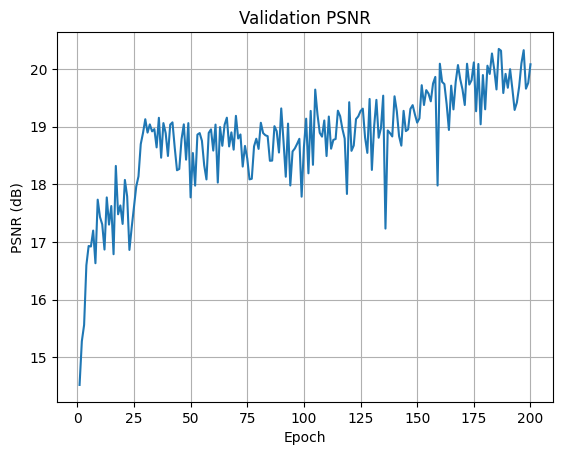

In [28]:
# Validation PSNR
plt.plot(epochs, val_psnr)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)
plt.savefig('RRDB_SE_CHECKPOINTS_color_jitter/validation_psnr.png', dpi=300, bbox_inches='tight')

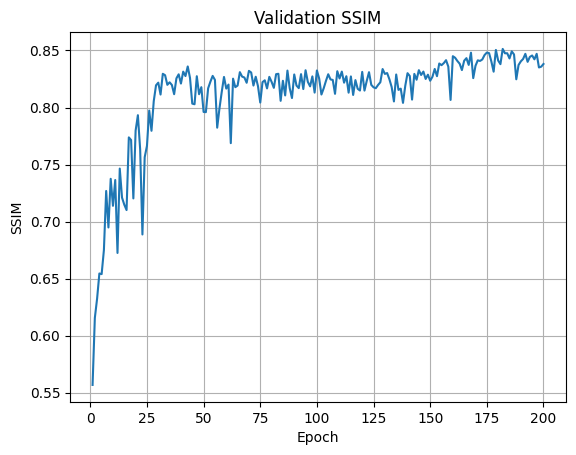

In [29]:
# Validation SSIM

plt.plot(epochs, val_ssim)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.grid(True)
plt.savefig('RRDB_SE_CHECKPOINTS_color_jitter/validation_ssim.png', dpi=300, bbox_inches='tight')

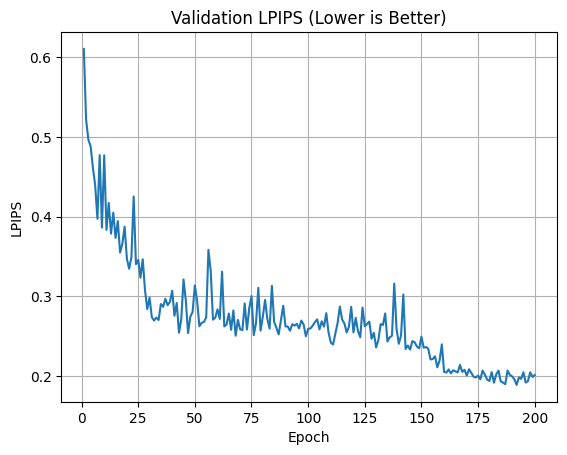

In [30]:
# Validation LPIPS
plt.plot(epochs, val_lpips)
plt.xlabel('Epoch')
plt.ylabel('LPIPS')
plt.title('Validation LPIPS (Lower is Better)')
plt.grid(True)
plt.savefig('RRDB_SE_CHECKPOINTS_color_jitter/validation_lpips.png', dpi=300, bbox_inches='tight')

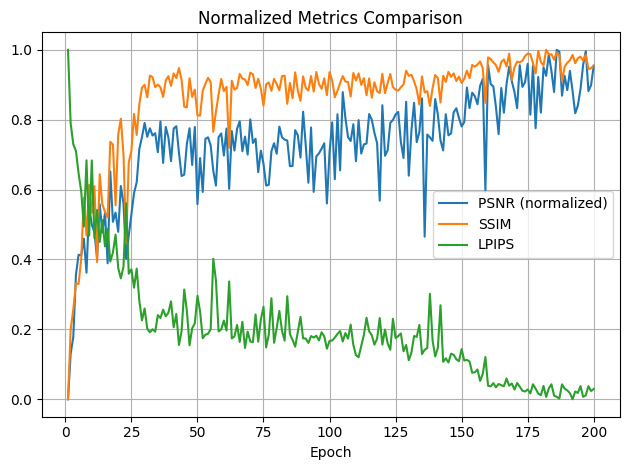

In [31]:
# Combined Metrics
val_psnr_norm = (np.array(val_psnr)-np.min(val_psnr))/(np.max(val_psnr)-np.min(val_psnr))
val_ssim_norm = (np.array(val_ssim)-np.min(val_ssim))/(np.max(val_ssim)-np.min(val_ssim))
val_lpips_norm = (np.array(val_lpips)-np.min(val_lpips))/(np.max(val_lpips)-np.min(val_lpips))

plt.plot(epochs, val_psnr_norm, label='PSNR (normalized)')
plt.plot(epochs, val_ssim_norm, label='SSIM')
plt.plot(epochs, val_lpips_norm, label='LPIPS')
plt.xlabel('Epoch')
plt.title('Normalized Metrics Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('RRDB_SE_CHECKPOINTS_color_jitter/training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

### TESTING ON REAL WORLD IMAGES (CAPTURED BY US)

In [32]:
generator = Generator().to(device)
# Load model with explicit CPU mapping
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_color_jitter/best_model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [33]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device (automatically handles CPU/GPU)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Image transformations
transform = transforms.Compose([
    transforms.Resize((225, 225)),
    transforms.ToTensor()
])

# Create file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    clear_output(wait=True)
    display(upload_widget)

    # Load model with proper device mapping
    generator = Generator().to(device)
    state_dict = torch.load("RRDB_SE_CHECKPOINTS_color_jitter/best_model.pth", map_location=device)
    # generator.load_state_dict(state_dict['generator'], strict=False)
    generator.load_state_dict(state_dict) # use this for best model.pth

    # Process uploaded image - NEW WAY to handle file upload
    if not upload_widget.value:
        return

    for filename, file_info in upload_widget.value.items():
        image_bytes = file_info['content']
        pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

        # Transform and process
        input_tensor = transform(pil_image).unsqueeze(0).to(device)

        generator.eval()
        with torch.no_grad():
            enhanced_tensor = generator(input_tensor)

        enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1).cpu().squeeze(0)
        enhanced_image = transforms.ToPILImage()(enhanced_tensor)

        # Display results
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(pil_image)
        plt.title("Original Low-Light")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(enhanced_image)
        plt.title("Enhanced High-Light")
        plt.axis("off")

        plt.show()



In [34]:
def on_upload_change(change):
    clear_output(wait=True)
    display(upload_widget)

    # Load model (with flexible state_dict handling)
    generator = Generator().to(device)
    state_dict = torch.load("RRDB_SE_CHECKPOINTS_color_jitter/best_model.pth", map_location=device)
    if isinstance(state_dict, dict) and 'generator' in state_dict:
        generator.load_state_dict(state_dict['generator'], strict=False)
    else:
        generator.load_state_dict(state_dict, strict=False)

    # Handle new FileUpload value format (tuple of dictionaries)
    if not upload_widget.value:
        return
    
    # Get first uploaded file (even if multiple=False)
    uploaded_file = upload_widget.value[0]  # Gets first tuple element
    
    # Process the image
    image_bytes = uploaded_file['content']
    pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    
    # Transform and process
    input_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    generator.eval()
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)
    
    enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1).cpu().squeeze(0)
    enhanced_image = transforms.ToPILImage()(enhanced_tensor)
    
    # Display results
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(pil_image)
    plt.title("Original Low-Light")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(enhanced_image)
    plt.title("Enhanced High-Light")
    plt.axis("off")
    
    plt.show()

In [35]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

In [36]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

In [37]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

In [38]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

In [39]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')